In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWiaz4u5ekfCAOS6MRg0WDy25L7naPMirb-6lONxGs2A3mKcZQ1ljW4
Mounted at /content/gdrive


In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
import os
# suppose you make a directory called "try_colab" under your google drive
# you can change this path to the directory you want to work at 
path = './drive/m231' 
os.chdir(path)
os.listdir('./')

['hw2', 'drive', 'data', 'MNIST_DCGAN_results']

In [ ]:
import torchvision
import torchvision.datasets as datasets
mnist_trainset = datasets.MNIST(root=path, train=True, download=True, transform=None)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:


# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:

transform = transforms.Compose([
        transforms.Scale(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
# Generator Code
import torch
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Starting Training Loop...
[0/10][0/469]	Loss_D: 1.4443	Loss_G: 2.5179	D(x): 0.4244	D(G(z)): 0.3182 / 0.1040
[0/10][50/469]	Loss_D: 0.1433	Loss_G: 12.0471	D(x): 0.9887	D(G(z)): 0.1180 / 0.0000
[0/10][100/469]	Loss_D: 0.1660	Loss_G: 5.1450	D(x): 0.9344	D(G(z)): 0.0812 / 0.0099
[0/10][150/469]	Loss_D: 0.0553	Loss_G: 5.2668	D(x): 0.9799	D(G(z)): 0.0320 / 0.0076
[0/10][200/469]	Loss_D: 0.2025	Loss_G: 4.2759	D(x): 0.8623	D(G(z)): 0.0274 / 0.0216
[0/10][250/469]	Loss_D: 0.2812	Loss_G: 6.0033	D(x): 0.7936	D(G(z)): 0.0080 / 0.0040
[0/10][300/469]	Loss_D: 0.2629	Loss_G: 4.7371	D(x): 0.9007	D(G(z)): 0.1225 / 0.0155
[0/10][350/469]	Loss_D: 0.2556	Loss_G: 3.9668	D(x): 0.9238	D(G(z)): 0.1409 / 0.0352
[0/10][400/469]	Loss_D: 4.6615	Loss_G: 3.3842	D(x): 0.9996	D(G(z)): 0.9796 / 0.1046
[0/10][450/469]	Loss_D: 0.1812	Loss_G: 2.9323	D(x): 0.9102	D(G(z)): 0.0725 / 0.0713


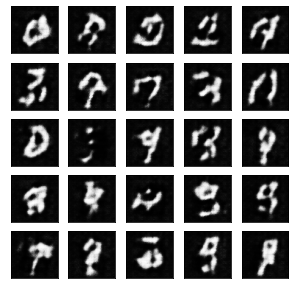

[1/10][0/469]	Loss_D: 0.6239	Loss_G: 2.0411	D(x): 0.6506	D(G(z)): 0.0822 / 0.1907
[1/10][50/469]	Loss_D: 0.7711	Loss_G: 2.3406	D(x): 0.8623	D(G(z)): 0.4021 / 0.1363
[1/10][100/469]	Loss_D: 4.8639	Loss_G: 0.5463	D(x): 0.0159	D(G(z)): 0.0008 / 0.6334
[1/10][150/469]	Loss_D: 0.4607	Loss_G: 3.4665	D(x): 0.9392	D(G(z)): 0.3030 / 0.0415
[1/10][200/469]	Loss_D: 0.2608	Loss_G: 2.4737	D(x): 0.8633	D(G(z)): 0.0985 / 0.1056
[1/10][250/469]	Loss_D: 0.4742	Loss_G: 2.3577	D(x): 0.8459	D(G(z)): 0.2420 / 0.1175
[1/10][300/469]	Loss_D: 0.3508	Loss_G: 2.2534	D(x): 0.8525	D(G(z)): 0.1559 / 0.1314
[1/10][350/469]	Loss_D: 1.0430	Loss_G: 3.3622	D(x): 0.8916	D(G(z)): 0.5403 / 0.0522
[1/10][400/469]	Loss_D: 0.3333	Loss_G: 2.4978	D(x): 0.8736	D(G(z)): 0.1628 / 0.1072
[1/10][450/469]	Loss_D: 0.2854	Loss_G: 2.7050	D(x): 0.8580	D(G(z)): 0.0994 / 0.0939


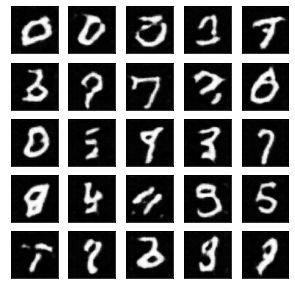

[2/10][0/469]	Loss_D: 0.2112	Loss_G: 3.9567	D(x): 0.9547	D(G(z)): 0.1449 / 0.0252
[2/10][50/469]	Loss_D: 0.7385	Loss_G: 1.6997	D(x): 0.5623	D(G(z)): 0.0519 / 0.2363
[2/10][100/469]	Loss_D: 0.2879	Loss_G: 2.3685	D(x): 0.8174	D(G(z)): 0.0692 / 0.1313
[2/10][150/469]	Loss_D: 1.2663	Loss_G: 0.9746	D(x): 0.3769	D(G(z)): 0.0353 / 0.4327
[2/10][200/469]	Loss_D: 1.1235	Loss_G: 1.4897	D(x): 0.4186	D(G(z)): 0.0101 / 0.2958
[2/10][250/469]	Loss_D: 0.1820	Loss_G: 3.1891	D(x): 0.9050	D(G(z)): 0.0722 / 0.0551
[2/10][300/469]	Loss_D: 0.3587	Loss_G: 2.2007	D(x): 0.8287	D(G(z)): 0.1260 / 0.1477
[2/10][350/469]	Loss_D: 0.9559	Loss_G: 3.2871	D(x): 0.8797	D(G(z)): 0.5032 / 0.0520
[2/10][400/469]	Loss_D: 0.3948	Loss_G: 2.1387	D(x): 0.7927	D(G(z)): 0.1235 / 0.1483
[2/10][450/469]	Loss_D: 0.4480	Loss_G: 2.9278	D(x): 0.8618	D(G(z)): 0.2238 / 0.0703


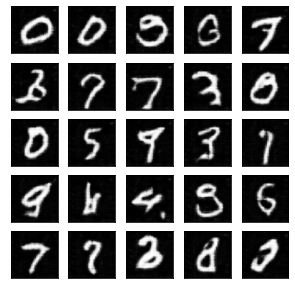

[3/10][0/469]	Loss_D: 0.3330	Loss_G: 4.8790	D(x): 0.9544	D(G(z)): 0.2294 / 0.0108
[3/10][50/469]	Loss_D: 0.1237	Loss_G: 3.4699	D(x): 0.9594	D(G(z)): 0.0745 / 0.0416
[3/10][100/469]	Loss_D: 2.2179	Loss_G: 4.5273	D(x): 0.9462	D(G(z)): 0.8155 / 0.0216
[3/10][150/469]	Loss_D: 1.6550	Loss_G: 4.7824	D(x): 0.9850	D(G(z)): 0.7386 / 0.0135
[3/10][200/469]	Loss_D: 0.6687	Loss_G: 2.4780	D(x): 0.8233	D(G(z)): 0.3330 / 0.1156
[3/10][250/469]	Loss_D: 0.6341	Loss_G: 2.2526	D(x): 0.7303	D(G(z)): 0.2258 / 0.1400
[3/10][300/469]	Loss_D: 0.5511	Loss_G: 3.7693	D(x): 0.9699	D(G(z)): 0.3580 / 0.0358
[3/10][350/469]	Loss_D: 0.1730	Loss_G: 4.7890	D(x): 0.9857	D(G(z)): 0.1356 / 0.0132
[3/10][400/469]	Loss_D: 0.4023	Loss_G: 2.6430	D(x): 0.7803	D(G(z)): 0.1089 / 0.0965
[3/10][450/469]	Loss_D: 0.1345	Loss_G: 3.2364	D(x): 0.9360	D(G(z)): 0.0619 / 0.0539


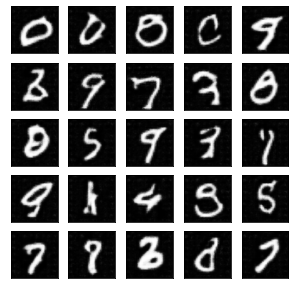

[4/10][0/469]	Loss_D: 0.1402	Loss_G: 2.9211	D(x): 0.8922	D(G(z)): 0.0187 / 0.0804
[4/10][50/469]	Loss_D: 0.1975	Loss_G: 5.9380	D(x): 0.9904	D(G(z)): 0.1565 / 0.0042
[4/10][100/469]	Loss_D: 0.8968	Loss_G: 3.2237	D(x): 0.8797	D(G(z)): 0.4755 / 0.0594
[4/10][150/469]	Loss_D: 0.6526	Loss_G: 2.0818	D(x): 0.6001	D(G(z)): 0.0525 / 0.1823
[4/10][200/469]	Loss_D: 0.2747	Loss_G: 4.3139	D(x): 0.9389	D(G(z)): 0.1734 / 0.0201
[4/10][250/469]	Loss_D: 0.2509	Loss_G: 3.7122	D(x): 0.8155	D(G(z)): 0.0271 / 0.0351
[4/10][300/469]	Loss_D: 0.3488	Loss_G: 2.9171	D(x): 0.8531	D(G(z)): 0.1501 / 0.0786
[4/10][350/469]	Loss_D: 0.3838	Loss_G: 1.8976	D(x): 0.7176	D(G(z)): 0.0112 / 0.2269
[4/10][400/469]	Loss_D: 0.1807	Loss_G: 3.3681	D(x): 0.9048	D(G(z)): 0.0706 / 0.0465
[4/10][450/469]	Loss_D: 0.0909	Loss_G: 4.6019	D(x): 0.9288	D(G(z)): 0.0143 / 0.0173


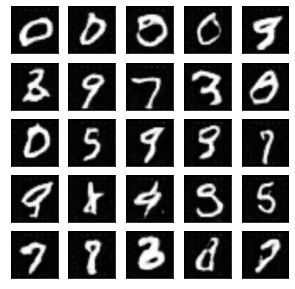

[5/10][0/469]	Loss_D: 0.7860	Loss_G: 1.6132	D(x): 0.6644	D(G(z)): 0.2558 / 0.2327
[5/10][50/469]	Loss_D: 0.3418	Loss_G: 2.6759	D(x): 0.7722	D(G(z)): 0.0488 / 0.0935
[5/10][100/469]	Loss_D: 0.1835	Loss_G: 4.5870	D(x): 0.9824	D(G(z)): 0.1438 / 0.0145
[5/10][150/469]	Loss_D: 0.0789	Loss_G: 3.7926	D(x): 0.9524	D(G(z)): 0.0284 / 0.0315
[5/10][200/469]	Loss_D: 2.1685	Loss_G: 21.6315	D(x): 0.9998	D(G(z)): 0.8238 / 0.0000
[5/10][250/469]	Loss_D: 0.8008	Loss_G: 1.2352	D(x): 0.5700	D(G(z)): 0.1672 / 0.3251
[5/10][300/469]	Loss_D: 0.3350	Loss_G: 3.2147	D(x): 0.9059	D(G(z)): 0.1891 / 0.0563
[5/10][350/469]	Loss_D: 0.2762	Loss_G: 3.4356	D(x): 0.9138	D(G(z)): 0.1528 / 0.0460
[5/10][400/469]	Loss_D: 0.5735	Loss_G: 2.3260	D(x): 0.8133	D(G(z)): 0.2816 / 0.1245
[5/10][450/469]	Loss_D: 0.1224	Loss_G: 3.2672	D(x): 0.9419	D(G(z)): 0.0577 / 0.0507


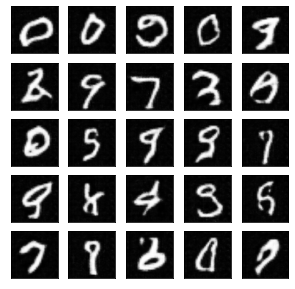

[6/10][0/469]	Loss_D: 0.6679	Loss_G: 11.6903	D(x): 0.9932	D(G(z)): 0.4289 / 0.0000
[6/10][50/469]	Loss_D: 1.7219	Loss_G: 5.6109	D(x): 0.9770	D(G(z)): 0.7445 / 0.0062
[6/10][100/469]	Loss_D: 0.2292	Loss_G: 2.6839	D(x): 0.8689	D(G(z)): 0.0692 / 0.0910
[6/10][150/469]	Loss_D: 0.1077	Loss_G: 3.9260	D(x): 0.9547	D(G(z)): 0.0563 / 0.0287
[6/10][200/469]	Loss_D: 11.1561	Loss_G: 1.9454	D(x): 0.0000	D(G(z)): 0.0000 / 0.2937
[6/10][250/469]	Loss_D: 0.2454	Loss_G: 2.7730	D(x): 0.8743	D(G(z)): 0.0925 / 0.0854
[6/10][300/469]	Loss_D: 0.6516	Loss_G: 4.8117	D(x): 0.9550	D(G(z)): 0.4045 / 0.0113
[6/10][350/469]	Loss_D: 1.1687	Loss_G: 6.3153	D(x): 0.9956	D(G(z)): 0.6271 / 0.0029
[6/10][400/469]	Loss_D: 0.1372	Loss_G: 3.6012	D(x): 0.9565	D(G(z)): 0.0835 / 0.0384
[6/10][450/469]	Loss_D: 0.0909	Loss_G: 3.7342	D(x): 0.9499	D(G(z)): 0.0330 / 0.0386


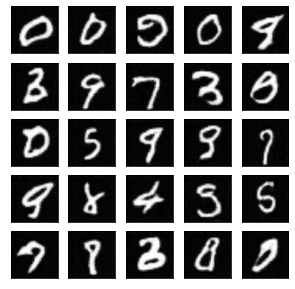

[7/10][0/469]	Loss_D: 0.0687	Loss_G: 4.2046	D(x): 0.9670	D(G(z)): 0.0328 / 0.0222
[7/10][50/469]	Loss_D: 0.6163	Loss_G: 5.3579	D(x): 0.9624	D(G(z)): 0.4019 / 0.0062
[7/10][100/469]	Loss_D: 0.1577	Loss_G: 3.4879	D(x): 0.9082	D(G(z)): 0.0509 / 0.0454
[7/10][150/469]	Loss_D: 0.9942	Loss_G: 1.7448	D(x): 0.6726	D(G(z)): 0.4003 / 0.2055
[7/10][200/469]	Loss_D: 0.3894	Loss_G: 3.4606	D(x): 0.9298	D(G(z)): 0.2505 / 0.0434
[7/10][250/469]	Loss_D: 0.4382	Loss_G: 3.8463	D(x): 0.9711	D(G(z)): 0.3060 / 0.0282
[7/10][300/469]	Loss_D: 0.0880	Loss_G: 4.1464	D(x): 0.9749	D(G(z)): 0.0579 / 0.0239
[7/10][350/469]	Loss_D: 0.2387	Loss_G: 7.6508	D(x): 0.9927	D(G(z)): 0.1945 / 0.0007
[7/10][400/469]	Loss_D: 0.2471	Loss_G: 5.1109	D(x): 0.9719	D(G(z)): 0.1834 / 0.0083
[7/10][450/469]	Loss_D: 0.5476	Loss_G: 3.0165	D(x): 0.7792	D(G(z)): 0.2009 / 0.0719


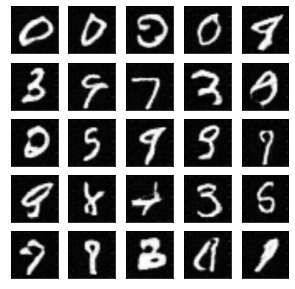

[8/10][0/469]	Loss_D: 0.1516	Loss_G: 3.1945	D(x): 0.9094	D(G(z)): 0.0477 / 0.0567
[8/10][50/469]	Loss_D: 0.2475	Loss_G: 4.5370	D(x): 0.9594	D(G(z)): 0.1731 / 0.0150
[8/10][100/469]	Loss_D: 0.0743	Loss_G: 4.1836	D(x): 0.9689	D(G(z)): 0.0400 / 0.0233
[8/10][150/469]	Loss_D: 0.7341	Loss_G: 1.8537	D(x): 0.7780	D(G(z)): 0.3489 / 0.1976
[8/10][200/469]	Loss_D: 0.2880	Loss_G: 4.8234	D(x): 0.9721	D(G(z)): 0.2102 / 0.0116
[8/10][250/469]	Loss_D: 1.1447	Loss_G: 2.1420	D(x): 0.7741	D(G(z)): 0.5151 / 0.1442
[8/10][300/469]	Loss_D: 0.1057	Loss_G: 4.2891	D(x): 0.9572	D(G(z)): 0.0573 / 0.0206
[8/10][350/469]	Loss_D: 0.0629	Loss_G: 4.5293	D(x): 0.9758	D(G(z)): 0.0365 / 0.0161
[8/10][400/469]	Loss_D: 1.3467	Loss_G: 1.9158	D(x): 0.7840	D(G(z)): 0.6097 / 0.1754
[8/10][450/469]	Loss_D: 0.4284	Loss_G: 3.5059	D(x): 0.9122	D(G(z)): 0.2553 / 0.0432


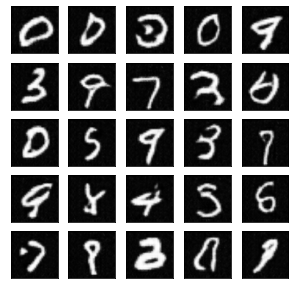

[9/10][0/469]	Loss_D: 1.3868	Loss_G: 7.8074	D(x): 0.9965	D(G(z)): 0.6851 / 0.0006
[9/10][50/469]	Loss_D: 0.4709	Loss_G: 3.1698	D(x): 0.8651	D(G(z)): 0.2450 / 0.0641
[9/10][100/469]	Loss_D: 0.0872	Loss_G: 4.1560	D(x): 0.9659	D(G(z)): 0.0489 / 0.0238
[9/10][150/469]	Loss_D: 0.0392	Loss_G: 4.6028	D(x): 0.9829	D(G(z)): 0.0212 / 0.0153
[9/10][200/469]	Loss_D: 0.0456	Loss_G: 4.9605	D(x): 0.9847	D(G(z)): 0.0290 / 0.0105
[9/10][250/469]	Loss_D: 0.8930	Loss_G: 1.1673	D(x): 0.6182	D(G(z)): 0.2878 / 0.3454
[9/10][300/469]	Loss_D: 0.3344	Loss_G: 2.5903	D(x): 0.8472	D(G(z)): 0.1171 / 0.1115
[9/10][350/469]	Loss_D: 0.2904	Loss_G: 1.8910	D(x): 0.8087	D(G(z)): 0.0509 / 0.2163
[9/10][400/469]	Loss_D: 0.3239	Loss_G: 3.5135	D(x): 0.9306	D(G(z)): 0.1951 / 0.0456
[9/10][450/469]	Loss_D: 0.7401	Loss_G: 2.3177	D(x): 0.7921	D(G(z)): 0.3444 / 0.1384


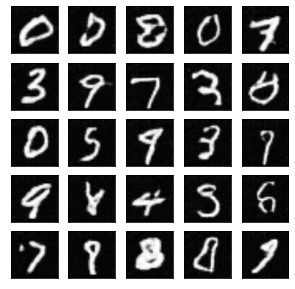

In [ ]:
# Training Loop
import itertools
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1
        #plot 5*5
    with torch.no_grad():
          test = netG(fixed_noise).detach().cpu()
    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
      ax[i, j].get_xaxis().set_visible(False)
      ax[i, j].get_yaxis().set_visible(False)
    for k in range(5*5):
      i = k // 5
      j = k % 5
      ax[i, j].cla()
      ax[i, j].imshow(test[k, 0].cpu().data.numpy(), cmap='gray')
    plt.show()

      

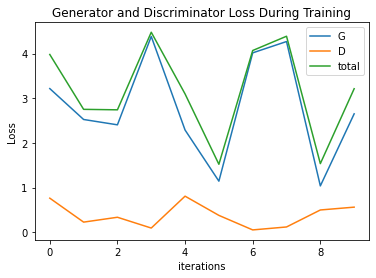

In [ ]:

e=slice(468,4691,469)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[e],label="G")
plt.plot(D_losses[e],label="D")
plt.plot(np.add(G_losses[e],D_losses[e]),label="total")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()